# Predictive Modeling of Coronary Heart Disease

Project Objective: To develop a robust machine learning pipeline capable of predicting the presence of heart disease using clinical patient data.

Methodology: I performed an iterative model selection process, comparing Multiple Logistic Regression, Random Forest, and Decision Tree classifiers. The Multiple Logistic Regression was selected as the final model as it outperformed more complex ensemble methods in both accuracy and clinical safety.

Key Findings:

* Performance: The final model achieved an 88.52% accuracy on unseen test data.

* Top three Predictors: Using p-value analysis (p<0.01), three variables were identified as the primary drivers of risk:

    1. Major Vessels (ca): The number of vessels colored by fluoroscopy (a direct measure of blockage).

    2. Chest Pain Type (cp): Specifically asymptomatic presentations.

    3. Sex: Highlighting demographic variance in the 1988 cohort.

* Error Audit: The model yielded only 3 False Negatives. Analysis revealed these patients went undetected by having zero visible major vessels (ca=0), suggesting the model relies heavily on physical calcification markers.

Research Limitations & Omitted Variables: As the data originates from 1988, results are subject to temporal bias regarding lifestyle and diagnostic technology. Additionally, the model may be subject to omitted variable bias; for instance, smoking habits, which correlate with chest pain in men (Friedman, 1975), were not recorded in this dataset. Future iterations should incorporate modern biomarkers and genetic history to address these "hidden" drivers.

In [23]:
%%capture
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


In [24]:
# Combine them temporarily just to see the full table
import pandas as pd

#Create a clean, readable table
df = pd.concat([X, y], axis = 1)
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  


Num is the dependent varible indicate whether the diease is present. Missing values is indicating that ca and thal have missing values. I will need to remove missing values to properly classify variables. This dateset has 13 predictors.

In [25]:
# Making X a standalone copy to break the link to the original object
X = heart_disease.data.features.copy()

# Fill missing 'ca' values with the mode
X['ca'] = X['ca'].fillna(X['ca'].mode()[0])
# Fill missing 'thal' values with the mode
X['thal'] = X['thal'].fillna(X['thal'].mode()[0])

# Verify that there are no more missing values
print("Missing values after fix:", X.isnull().sum().sum())

Missing values after fix: 0


In [26]:
y_binary = y['num'].apply(lambda x: 1 if x > 0 else 0)
df = pd.concat([X, y_binary], axis = 1)
# check for missing values
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


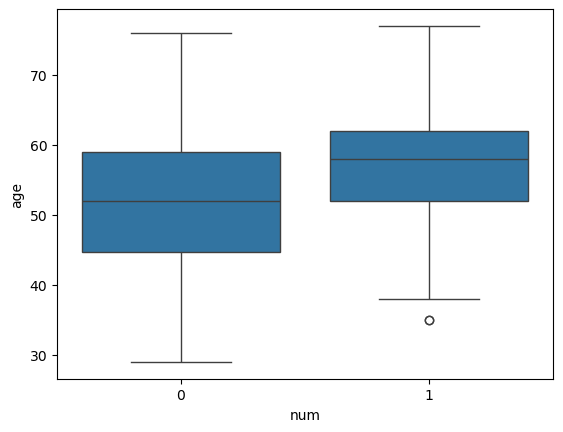

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x = y_binary, y = X['age'])
plt.show() 

In [30]:
# age does have a correlation with heart disease
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


 I will then follow with:
 1. Logistic Regression
 2. Random Forest
 3. Classification Tree

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 

In [34]:
# Split into training and testing sets (Binary: 0 = Healthy, 1 = Sick)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size = 0.2, random_state = 42)

# Scale the date
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Multiple Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Evaluate 

accuracy = model.score(X_test_scaled, y_test)
print(f"The model's accuracy on unseen data is: {accuracy: .2%}")

The model's accuracy on unseen data is:  88.52%


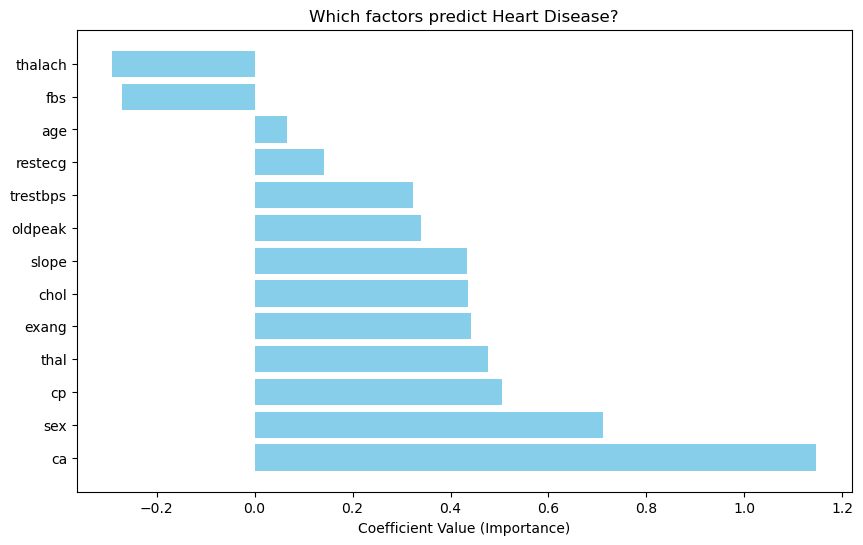

In [37]:
# Get the coefficients from the model
importance = model.coef_[0]
feature_names = X.columns

# Create a datafram for easy plotting
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = False)

# Plotting
plt.figure(figsize = (10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color = 'skyblue')
plt.xlabel('Coefficient Value (Importance)')
plt.title('Which factors predict Heart Disease?')
plt.show()

In [44]:
import statsmodels.api as sm

# Convert the scaled array back into a Dataframe with original names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X.columns)

# Add a constant (intercept)
X_train_const = sm.add_constant(X_train_scaled_df)

#Fit the Logit model
logit_model = sm.Logit(y_train.reset_index(drop = True), X_train_const)
result = logit_model.fit()

# Print summary 
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.350314
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    num   No. Observations:                  242
Model:                          Logit   Df Residuals:                      228
Method:                           MLE   Df Model:                           13
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                  0.4897
Time:                        17:44:06   Log-Likelihood:                -84.776
converged:                       True   LL-Null:                       -166.12
Covariance Type:            nonrobust   LLR p-value:                 5.638e-28
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1937      0.205     -0.947      0.344      -0.595       0.207
age            0.0493      0.

Ca, Sex, and CP are all significant at the 1% level. stongest factor is ca (Number of Major Vessels) or vessels colored by fluoroscopy. Effectively, the more vessels that show up as "black" or "calcified", the higher the probability of disease. Sex is the second highest where 1 is coded to be male and 0 as female. This indicates that being male is a significant risk factor in this specific cohort. Third is CP, indicating chest pain. This inficates that type of pain ig a major signal for model.

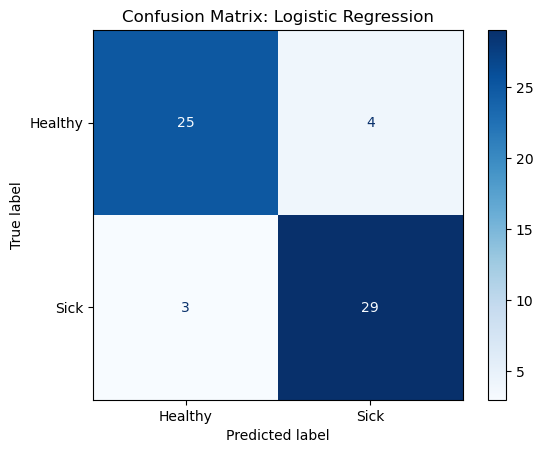

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions on the test set
y_pred = model.predict(X_test_scaled)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it visually
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Healthy','Sick'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

False-Negatives: 3 (sick people labeled as healthy) \
False-Positives: 4 (healthy people labed as sick)

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and Fit the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

# Check Accurary 
rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy: .2%}")
print(f"Logistic Regression Accuracy: 88.52%")

Random Forest Accuracy:  86.89%
Logistic Regression Accuracy: 88.52%


Random Forest Model Accuracy is less than the Logistic Regression. The data is likely linearly separable. Meaing that sex, cp, and ca have a clear, direct relationship with heart disease that doesn't require complex "if-then" to determine. The random forest is likely overfitting.

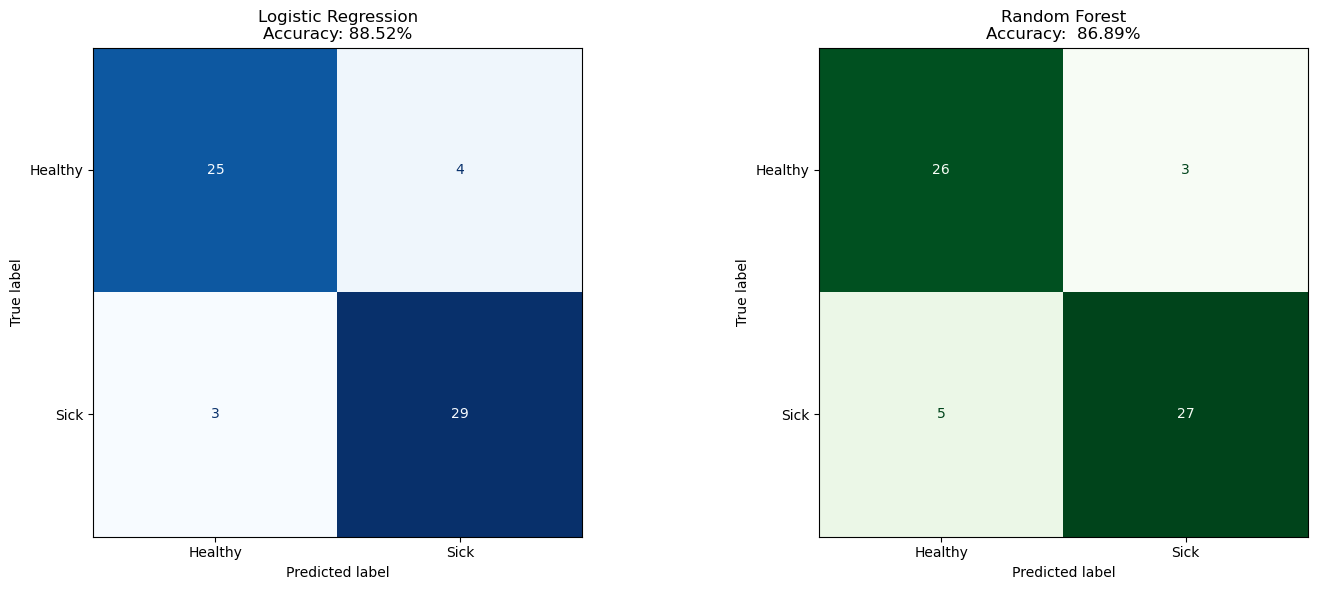

In [54]:
# Get predictions for both models
y_pred_logit = model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

#Create the confusion matrices 
cm_logit = confusion_matrix(y_test, y_pred_logit)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# set up the plotting area 
fig, ax = plt.subplots(1,2, figsize = (15, 6))

# Plot Logistic Regression Matrix
disp_logit = ConfusionMatrixDisplay(confusion_matrix = cm_logit, display_labels = ['Healthy','Sick'])
disp_logit.plot(ax=ax[0], cmap = 'Blues', colorbar = False)
ax[0].set_title(f'Logistic Regression\nAccuracy: 88.52%')

# Plot Random Forest Matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = ['Healthy','Sick'])
disp_rf.plot(ax = ax[1], cmap = 'Greens', colorbar = False)
ax[1].set_title(f'Random Forest\nAccuracy: {rf_model.score(X_test, y_test): .2%}')

plt.tight_layout()
plt.show()

Logistic Regression False Negatives: 3 \
Random Forest False Negatives: 5

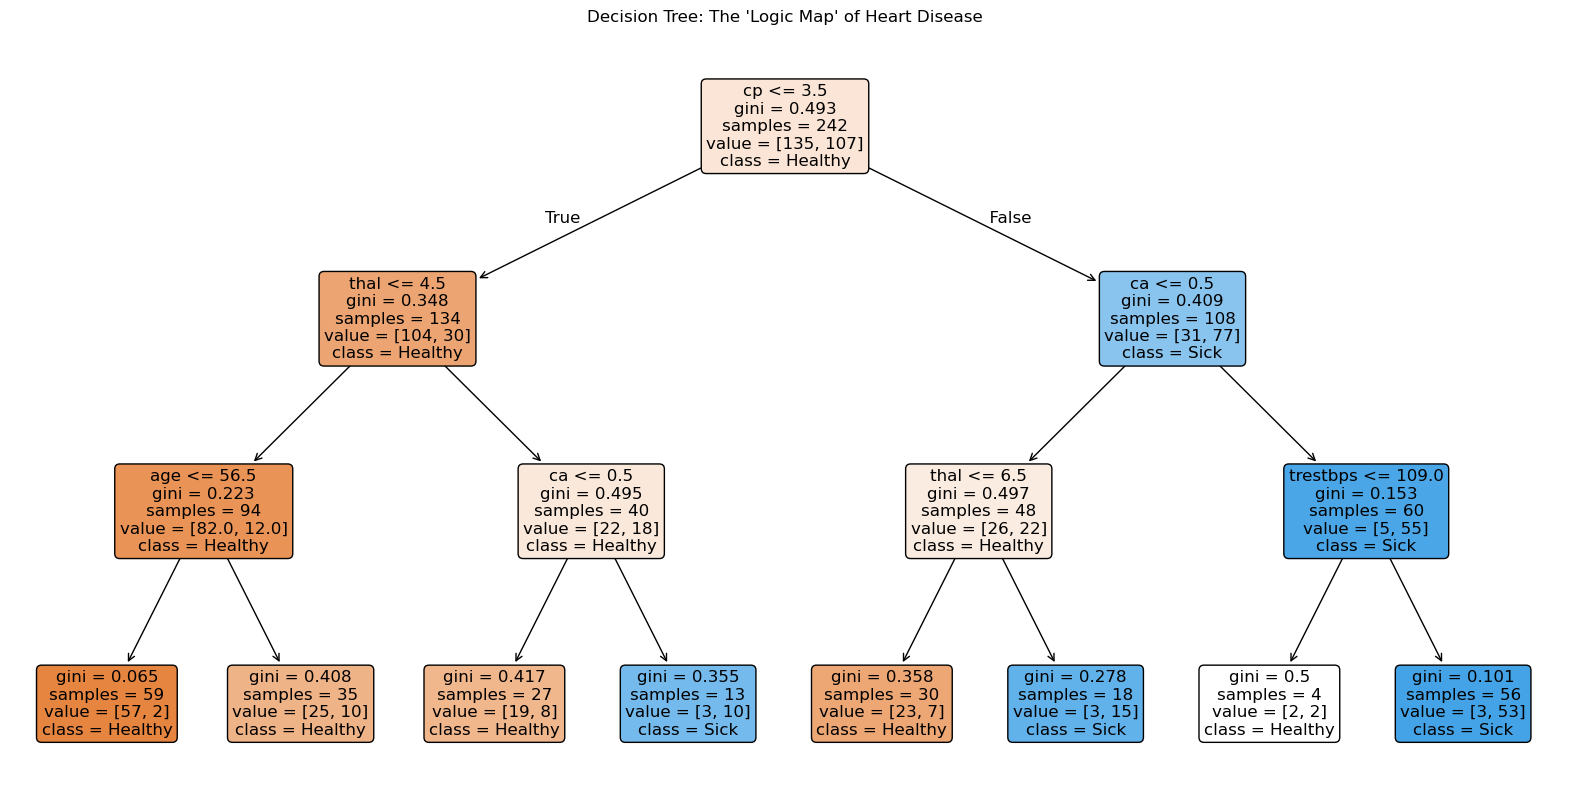

In [55]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Fit a simple tree (max_depth = 3)
dt_model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dt_model.fit(X_train, y_train )

# Plot the tree
plt.figure(figsize = (20,10))
plot_tree(dt_model, 
          feature_names = X.columns, 
          class_names = ['Healthy','Sick'],
          filled = True,
          rounded = True,
          fontsize = 12)
plt.title("Decision Tree: The 'Logic Map' of Heart Disease")
plt.show()

In [60]:
from sklearn.metrics import accuracy_score

# get the predictions and accuracy
y_pred_dt = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_cm = confusion_matrix(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {dt_acc: .2%}")
print(f"Logistic Regression Accuracy: 88.52%")
print("-" * 30)
print(f"Decision Tree False Negatives: {dt_cm[1,0]}")
print(f"Logistic Regression False Negatives: 3")

Decision Tree Accuracy:  86.89%
Logistic Regression Accuracy: 88.52%
------------------------------
Decision Tree False Negatives: 5
Logistic Regression False Negatives: 3


In [62]:
import numpy as np


# Takes a dictionary of patient data and return the probability of heart disease.
def heart_disease_risk_calculator(patient_data):
    # Convert patient dict to a 2D array 
    patient_df = pd.DataFrame([patient_data])

    # Scaling the new data 
    patient_scaled = scaler.transform(patient_df)

    # Predicting the probablity, will return [prob_healthy, prob_sick]
    probability = model.predict_proba(patient_scaled)[0][1]

    return probability

In [64]:
# Testing our on a hypothetical patient to see accuracy
# Note that the three variaables (sex, chest pains, and major vessels) will he altered

test_patient = {
    'age': 65,
    'sex': 1,      # Male
    'cp': 4,       # Asymptomatic/Typical Chest Pain
    'trestbps': 145,
    'chol': 233,
    'fbs': 1,
    'restecg': 0,
    'thalach': 150,
    'exang': 0,
    'oldpeak': 2.3,
    'slope': 3,
    'ca': 2,       # 2 major vessels (Significant)
    'thal': 7
}

risk_score = heart_disease_risk_calculator(test_patient)
print(f"The patient's calculated risk of heart disease is: {risk_score: .2%}")

The patient's calculated risk of heart disease is:  97.05%


Due to the size of the sample (303 rows) I was unable to utilize other machine learning methods, such as nueral networks, to test if there is an alternative prediction method with greater than 88.52% accuracy. 

While Neural Networks generally require larger datasets to avoid overfitting, the Logistic Regression provided a high-performing and highly interpretable baseline for this sample size

This data is from 1988 and as a result cultural norms, and technology have changed, therefore other variables that were not measurable could be introduced, as well as more modern datasets could better than the models to predict risk of heart disease in the current age. 

Additional variables could be beneficial and omitted vaiable bias could exist, such as habitual variables that have thier own relationships with chest pains, major vessels, and sex. In other words, chest pains could be a result of smoking habits as explained by Gary D. Friedman in the article "Cigarette Smoking and Chest Pain" expressing that "a greater proportion of cigarette smokers than nonsmokers (excesses averaging 1.6-fold in white men, 1.3-fold in white women) admitting to nine types of chest pain."(Friedman, 1975). 

In [65]:
# False negative check
# Creating a data frame for the test results
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred_logit

# Filtering for false negatives
false_negatives = results[(results['Actual'] ==1) & (results['Predicted'] == 0)] 

# View the false negative patients
print(f"Number of False Negatives: {len(false_negatives)}")
display(false_negatives)

Number of False Negatives: 3


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Actual,Predicted
268,40,1,4,152,223,0,0,181,0,0.0,1,0.0,7.0,1,0
57,41,1,4,110,172,0,2,158,0,0.0,1,0.0,7.0,1,0
184,60,0,4,158,305,0,2,161,0,0.0,1,0.0,3.0,1,0


An audit of the False Negatives reveals that these patients 'mimicked' healthy profiles by having zero major vessels (ca=0). This suggests the model may be over-reliant on physical blockages and could be improved by incorporating lifestyle biomarkers that catch disease before physical calcification occurs